# Numerics for the SYK quantum batteries

let us start by including the relevant packages

In [1]:
include("/home/dario/Documents/ChargingPower/src/ChargingPower.jl")
using .ChargingPower

In [2]:
using SparseArrays
using KrylovKit
using ExponentialUtilities
using Graphs
using Plots
using Statistics

and let us set the parameters for the time evolution

In [3]:
min_t = 10^-1 
max_t = 10^3
number_of_points = 10^4
points = exp.(log(min_t):((log(max_t) - log(min_t)) / (number_of_points - 1)):log(max_t))

10000-element Vector{Float64}:
   0.10000000000000002
   0.10009215505167934
   0.10018439502889412
   0.10027672000990762
   0.10036913007305502
   0.10046162529674393
   0.10055420575945404
   0.10064687153973735
   0.1007396227162184
   0.1008324593675941
   ⋮
 992.6580753801127
 993.5728599424777
 994.488487525029
 995.4049589046521
 996.3222748589505
 997.240436166239
 998.1594436055545
 999.0792979566509
 999.9999999999998

## The Z-model charging power

Let us first collect the data for the Z-model battery

In [17]:
n_majorana_list = 14:2:18
n_samples = 500;

In [18]:
average_power_list = Array{Float64}[]

Array{Float64}[]

In [15]:
for n_majorana in n_majorana_list
    power_single_size_list = Array{Float64}[] 
    majorana_matrices = majorana_operators(n_majorana)
    graph = complete_graph(n_majorana)
    battery_hamiltonian = Z_model_hamiltonian(majorana_matrices)
    for i in 1:n_samples 
        charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
        ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
        e_0 = real(ground_state_rough[1][1])
        ground_state = ground_state_rough[2][1]
        power_list = [0.0]
        for index in eachindex(points) 
            if index != length(points)
                ground_state = expv(- im * (points[index + 1] - points[index]), charging_hamiltonian, ground_state)
                push!(power_list, 2 * (real(ground_state' * battery_hamiltonian * ground_state) - e_0) / (points[index + 1] + points[index]))
            end
        end
        push!(power_single_size_list, power_list)
    end
    push!(average_power_list, mean(power_single_size_list))
end

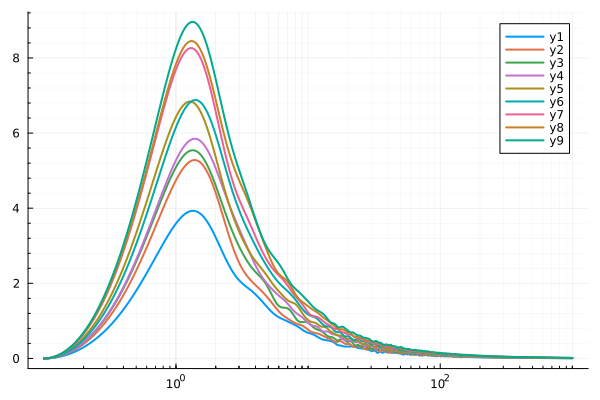

In [16]:
plot(points[2: length(points)], [list[2:length(points)] for list in average_power_list], xaxis=:log, linewidth=2, minorgrid=true)   